In [1]:


from torchvision.utils import make_grid
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
import os
import random

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

os.makedirs('./dataset', exist_ok=True)
dataset = datasets.STL10('/dataset', split='train', download=True, transform=transforms.ToTensor())

100%|██████████| 2640397119/2640397119 [01:08<00:00, 38519101.02it/s]


Extracting /dataset/stl10_binary.tar.gz to /dataset


new


In [3]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
valid_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

print()
print("Train Dataset Size :", len(train_dataset))
print("Valid Dataset Size :", len(valid_dataset))
print("Test Dataset Size :", len(test_dataset))



Train Dataset Size : 4000
Valid Dataset Size : 500
Test Dataset Size : 500


In [4]:

# Applying Augmentation

def get_mean(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])
  return [meanR, meanG, meanB]

def get_std(dataset):
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])
  return [stdR, stdG, stdB]

_mean = get_mean(train_dataset)
_std = get_std(train_dataset)

train_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)), transforms.RandomRotation(degrees=3), transforms.RandomHorizontalFlip(p = 0.5), transforms.ToTensor(), transforms.Normalize(_mean, _std)])
valid_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(_mean, _std)])
test_transform = transforms.Compose([transforms.Resize((96, 96)), transforms.ToTensor(), transforms.Normalize(_mean, _std)])

train_dataset.transform = train_transform
valid_dataset.transform = valid_transform
test_dataset.transform = test_transform


idx_to_class = train_dataset.dataset.classes
print("Number of classes = ", len(idx_to_class))
print(idx_to_class)

Number of classes =  10
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [5]:
image, label = train_dataset[0]
image.shape

torch.Size([3, 96, 96])

In [6]:
classCount = {}
for i,j in train_dataset:
    labels = idx_to_class[j]
    if labels not in classCount:
        classCount[labels] = 0
    classCount[labels] += 1
classCount

{'car': 400,
 'dog': 404,
 'ship': 399,
 'cat': 389,
 'horse': 389,
 'airplane': 415,
 'deer': 402,
 'bird': 408,
 'monkey': 394,
 'truck': 400}

In [5]:

# DataLoader Initialize

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# For Transfer Learning

import torch.nn as nn
from torch import optim

Images Shape: torch.Size([128, 3, 96, 96])


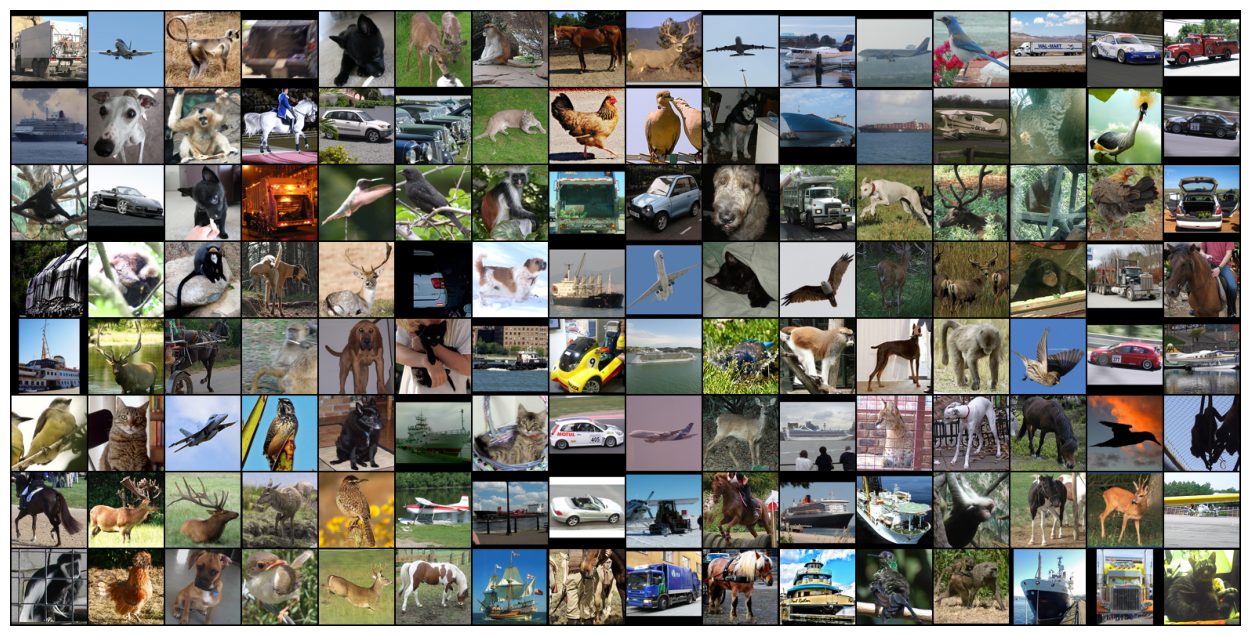

In [8]:

for images, labels in train_dataloader:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
# Pre-Trained(ImageNet) ResNet50 Model

from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True).to(device)

# Layer Freezing
count_layer = 0
for param in model.parameters():
  if count_layer > 60:
    break
  param.requires_grad = False
  count_layer += 1

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


In [10]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [7]:
import time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(valid_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
        avg_train_loss = train_loss/train_size
        avg_train_acc = train_acc/train_size
        avg_valid_loss = valid_loss/valid_size
        avg_valid_acc = valid_acc/valid_size
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        print("Epoch: {:02d}, Training: Loss - {:.4f}, Accuracy - {:.2f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.2f}%, Time: {:.2f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    return model, history, best_epoch

In [8]:

lr = 0.0001
num_epochs = 15
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss().to(device)
trained_model, history, best_epoch = train_and_validate(model, loss_func, optimizer, num_epochs)

Epoch: 1/15
Epoch: 00, Training: Loss - 1.2973, Accuracy - 65.58%, 
		Validation : Loss - 0.4747, Accuracy - 87.40%, Time: 16.63s
Epoch: 2/15
Epoch: 01, Training: Loss - 0.2309, Accuracy - 93.90%, 
		Validation : Loss - 0.2921, Accuracy - 90.40%, Time: 7.85s
Epoch: 3/15
Epoch: 02, Training: Loss - 0.0695, Accuracy - 98.40%, 
		Validation : Loss - 0.3021, Accuracy - 92.20%, Time: 7.98s
Epoch: 4/15
Epoch: 03, Training: Loss - 0.0312, Accuracy - 99.55%, 
		Validation : Loss - 0.3302, Accuracy - 91.40%, Time: 7.67s
Epoch: 5/15
Epoch: 04, Training: Loss - 0.0226, Accuracy - 99.65%, 
		Validation : Loss - 0.3342, Accuracy - 91.40%, Time: 8.01s
Epoch: 6/15
Epoch: 05, Training: Loss - 0.0163, Accuracy - 99.67%, 
		Validation : Loss - 0.3170, Accuracy - 91.80%, Time: 8.03s
Epoch: 7/15
Epoch: 06, Training: Loss - 0.0225, Accuracy - 99.45%, 
		Validation : Loss - 0.3622, Accuracy - 90.00%, Time: 7.83s
Epoch: 8/15
Epoch: 07, Training: Loss - 0.0235, Accuracy - 99.45%, 
		Validation : Loss - 0.4241

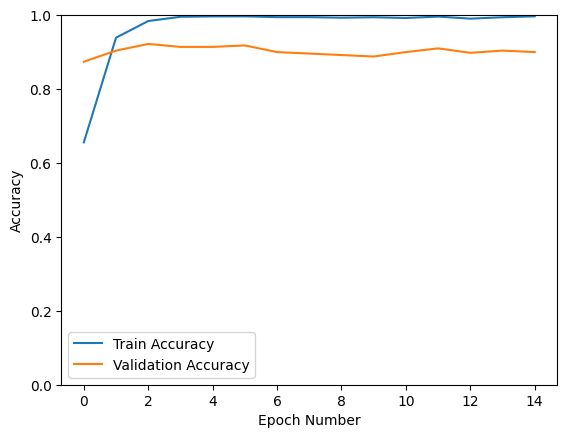

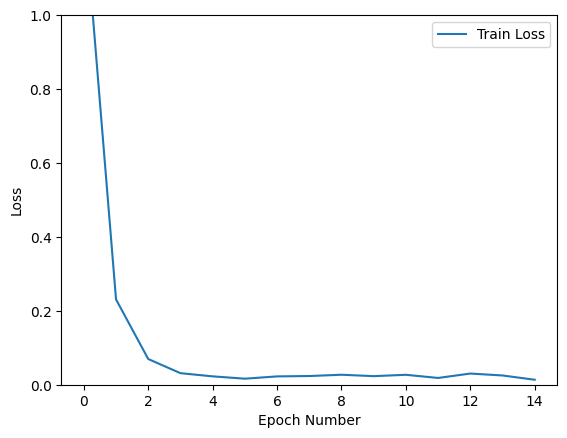

In [10]:
history = np.array(history)
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()
plt.plot(history[:,0:1])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

In [14]:
def CalcTestAcc(model, loss_criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    with torch.no_grad():
        model.eval()
        for j, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)
            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    avg_test_loss = test_loss/test_size
    avg_test_acc = test_acc/test_size

    print("Test accuracy : " + str(avg_test_acc))


CalcTestAcc(model, loss_func)

Test Batch number: 000, Test: Loss: 0.3013, Accuracy: 0.9219
Test Batch number: 001, Test: Loss: 0.2035, Accuracy: 0.9062
Test Batch number: 002, Test: Loss: 0.1607, Accuracy: 0.9531
Test Batch number: 003, Test: Loss: 0.2337, Accuracy: 0.9219
Test Batch number: 004, Test: Loss: 0.3936, Accuracy: 0.8906
Test Batch number: 005, Test: Loss: 0.4898, Accuracy: 0.8594
Test Batch number: 006, Test: Loss: 0.3289, Accuracy: 0.8750
Test Batch number: 007, Test: Loss: 0.2774, Accuracy: 0.8462
Test accuracy : 0.8980000009536743


In [12]:

correct_predction = {label: 0 for label in idx_to_class}
total_predction = {label: 0 for label in idx_to_class}
confusion_matrix = torch.zeros(len(idx_to_class), len(idx_to_class))


with torch.no_grad():
  model.eval()
  n_correct=0.0

  for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        output_labels = torch.argmax(outputs,dim=1)

        n_correct += sum(labels==output_labels)

        #Confusion matrix
        for t, p in zip(labels.view(-1), output_labels.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        #Checking Classwise Correct Prediction
        for j in range(52):
          if labels[j] == output_labels[j]:
                correct_predction[idx_to_class[labels[j]]] += 1

          total_predction[idx_to_class[labels[j]]] += 1

print(f'Accuracy on test data: {100 * n_correct // len(test_dataset)} %')

for label, correct_count in correct_predction.items():
    print("Accuracy for Class : ",label," is ",str(round(100 * (float(correct_count) / total_predction[label]),2)),"%",sep=" ")

print(confusion_matrix)

Accuracy on test data: 90.0 %
Accuracy for Class :  airplane  is  92.11 %
Accuracy for Class :  bird  is  72.73 %
Accuracy for Class :  car  is  96.88 %
Accuracy for Class :  cat  is  88.37 %
Accuracy for Class :  deer  is  95.45 %
Accuracy for Class :  dog  is  84.78 %
Accuracy for Class :  horse  is  86.0 %
Accuracy for Class :  monkey  is  100.0 %
Accuracy for Class :  ship  is  94.44 %
Accuracy for Class :  truck  is  92.11 %
tensor([[39.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.],
        [ 0., 39.,  0.,  3.,  2.,  1.,  0.,  7.,  0.,  0.],
        [ 0.,  0., 37.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0., 50.,  0.,  3.,  0.,  3.,  0.,  0.],
        [ 0.,  0.,  0.,  1., 51.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2.,  2., 45.,  0.,  4.,  0.,  0.],
        [ 2.,  0.,  0.,  0.,  1.,  7., 50.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 52.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 44.,  1.],
        [ 1.,  0.,  0.,  0

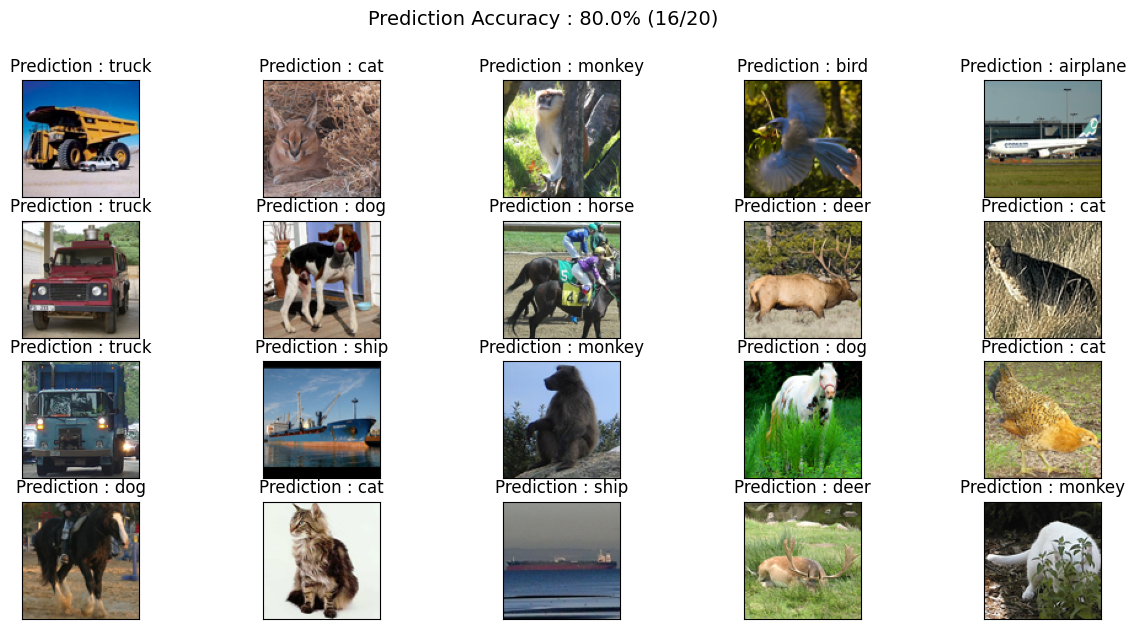

In [14]:
def visualize_predict(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    test_acc = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
        plt.figure(figsize=(15,7))
        for i in range(20):
            plt.subplot(4,5,i+1)
            plt.title("Prediction : " + idx_to_class[pred[i]])
            if pred[i] == labels[i]:
              test_acc += 1
            plt.xticks([])
            plt.yticks([])
            plt.imshow(np.transpose(inputs[i].cpu().numpy(), (1, 2, 0)))
        plt.suptitle("Prediction Accuracy : " + str(test_acc / 20 * 100) + "%" + " (" + str(test_acc) + "/20)", fontsize=14)


visualize_predict(model, loss_func, test_dataloader)